## Notebook to illustrate how the probablistic jerk finder works.

#### Here is an assumed underlying piecewise linear time dependence with a change in slope at t=50:

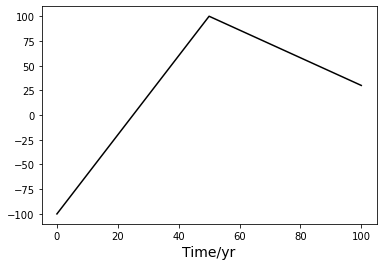

In [1]:
import matplotlib.pyplot as plt
import numpy as np
discretise_size = 400

time_for_plotting = np.linspace(0,100,discretise_size,endpoint=True)
plt.figure()
plt.plot([0,50,100],[-100,100,30],'k');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_raw_signal.pdf',bbox_inches='tight')

#### Now we sample the timeseries at NUM_DATA points (here, assumed equally spaced) and add noise (assumed normally distributed with known standard deviation)

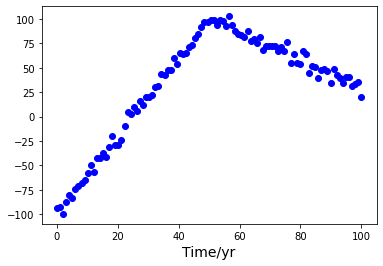

In [27]:
plt.figure()
np.random.seed(seed = 10)
NUM_DATA = 100
TIMES = np.linspace(0,100,NUM_DATA,dtype=float)
Y = np.interp(TIMES,[0,50,100],[-100,100,30]) 
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_sampled_signal.pdf',bbox_inches='tight')
plt.close()


plt.figure()
np.random.seed(seed = 10)
NUM_DATA = 100
TIMES = np.linspace(0,100,NUM_DATA,dtype=float)
delta_Y = 5 * np.ones(NUM_DATA)
Y = np.interp(TIMES,[0,50,100],[-100,100,30]) + np.random.normal(loc=0,scale=delta_Y)
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_noised_signal.pdf',bbox_inches='tight')

In [7]:
import os
import sys
sys.path.append( os.path.abspath('..') )
sys.path.append( os.path.abspath('.') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = -200
Y_MAX = 200

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)

# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 100
NBINS = 1000
credible = 95
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000+burn_in
time_intervals_nbins = 101  #collect change point histogram over 101 bins for the 100 time units, f
#[-0.5,0.5], ....[99.5, 100.5]
time_intervals_edges = np.linspace(TIMES_MIN-0.5, TIMES_MAX+0.5, time_intervals_nbins+1, endpoint = True)

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX, dtype=int)
av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

CP = np.zeros( time_intervals_nbins, dtype=int )

(Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[14.03419971  7.73660564  1.57933939  1.57909274]


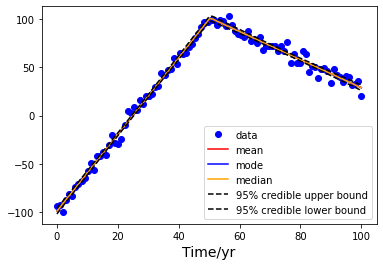

In [8]:
plt.figure()
plt.plot(TIMES,Y,'bo', label='data')
plt.plot(time_for_plotting,AV,'r', label='mean')
plt.plot(time_for_plotting,MODE, 'b',  label='mode')
plt.plot(time_for_plotting,MEDIAN, 'orange',  label='median')
plt.plot(time_for_plotting, SUP,'k--',  label='95% credible upper bound')
plt.plot(time_for_plotting,INF, 'k--',  label='95% credible lower bound')
plt.legend(loc='lower right')
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_posterior.pdf',bbox_inches='tight')

#### Histogram of vertex probability with original time series. The vertical scale indicates the probability that an internal vertex is in each (1 time unit) bin:

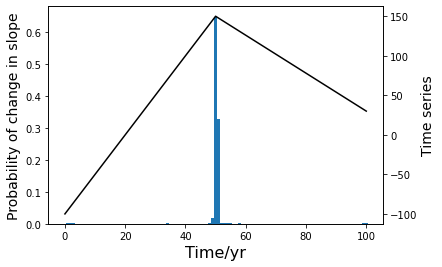

In [13]:
# Binning in code:
# bins are 0-1, 1-2, 2-3, 3-4, etc. with left edges at 0,1,2,3,4,...
# 
plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax = plt.gca()
plt.bar(left_edges, CP/fac, align='edge', width = time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins])
ax2 = ax.twinx()
plt.plot([0,50,100],[-100,150,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Probability of change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example1_jerk_timing.pdf',bbox_inches='tight')

In [15]:
from scipy.signal import find_peaks
peaks,_ = find_peaks(CP/fac, height=0.1)
print('Most probable change in slope is between {0:f} and {1:f}'.format
      (left_edges[peaks][0], left_edges[peaks+1][0]))

Most probable change in slope is between 49.500000 and 50.500000


#### Calculate the timeseries of the absolute change in slope from the average and median solutions

In [16]:
# Define a function to calculate the change in slope. Uses one-sided differences excluding the query point.
# This avoids the case where an apex of the function modelled, is in between two grid points x_i, and x_{i+1}. 
# Here, the left one-sided gradient at x_i, and the right one-sided gradient at x_{i+1} will be accurate, 
# but using x_i and x_{i+1} to calculate the gradient will give a large error.

def calc_delta_slope(timeseries, delta_t):
    delta_slope = np.zeros( len(timeseries) )
    
    for i in range(len(timeseries)):
        if i > 2 and i < len(timeseries)-2 :
            delta_slope[i] = abs(timeseries[i+2] -  timeseries[i+1] - timeseries[i-1] + timeseries[i-2] )/delta_t
    return delta_slope

    

In [17]:
true_soln = np.interp(time_for_plotting,[0,50,100],[-100,100,30])
calc_delta_slope(true_soln,time_for_plotting[1] - time_for_plotting[0]).max()

5.400000000000121

In [18]:
print('Analytic change in slope is ', 70./50  + 200./50)

Analytic change in slope is  5.4


Peak of delta_slope for median 4.788000
Peak of delta_slope for average 3.454886
Peak of delta_slope for average 5.400000
Time of max delta_slope for median 50.375940
Time of max delta_slope for average 50.375940
Time of max delta_slope for true solution 49.874687


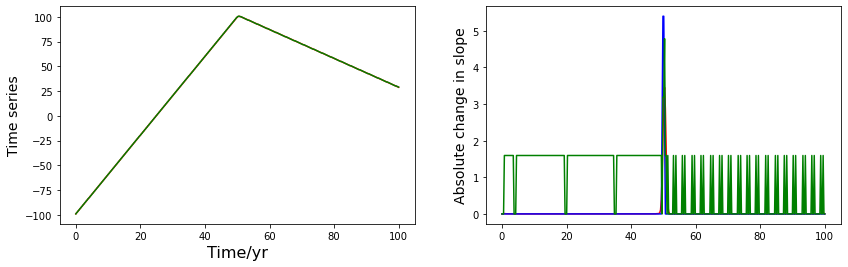

In [19]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))

true_soln = np.interp(time_for_plotting,[0,50,100],[-100,100,30])
ax1.plot(time_for_plotting, AV,'r') 
ax.plot(time_for_plotting, true_soln,'b') 
ax1.plot(time_for_plotting, MEDIAN,'g') 

ax2.plot(time_for_plotting, calc_delta_slope(AV,time_for_plotting[1] - time_for_plotting[0]),'r') 
ax2.plot(time_for_plotting, calc_delta_slope(true_soln,time_for_plotting[1] - time_for_plotting[0]),'b') 
ax2.plot(time_for_plotting, calc_delta_slope(MEDIAN,time_for_plotting[1] - time_for_plotting[0]),'g') 

ax1.set_xlabel('Time/yr',fontsize=16)
ax1.set_ylabel('Time series',fontsize=14)
ax2.set_ylabel('Absolute change in slope',fontsize=14)
#plt.savefig('example1_jerk_delta_slope.pdf',bbox_inches='tight')

print( 'Peak of delta_slope for median {0:f}'.format(calc_delta_slope(MEDIAN,time_for_plotting[1] - time_for_plotting[0]).max() ))
print( 'Peak of delta_slope for average {0:f}'.format(calc_delta_slope(AV,time_for_plotting[1] - time_for_plotting[0]).max() ))
print( 'Peak of delta_slope for average {0:f}'.format(calc_delta_slope(true_soln,time_for_plotting[1] - time_for_plotting[0]).max() ))

print( 'Time of max delta_slope for median {0:f}'.format(time_for_plotting[calc_delta_slope(MEDIAN,time_for_plotting[1] - time_for_plotting[0]).argmax()]))
print( 'Time of max delta_slope for average {0:f}'.format(time_for_plotting[calc_delta_slope(AV,time_for_plotting[1] - time_for_plotting[0]).argmax()]))
print( 'Time of max delta_slope for true solution {0:f}'.format(time_for_plotting[calc_delta_slope(true_soln,time_for_plotting[1] - time_for_plotting[0]).argmax()]))

#### Results from binning the absolute change for each model from the ensemble

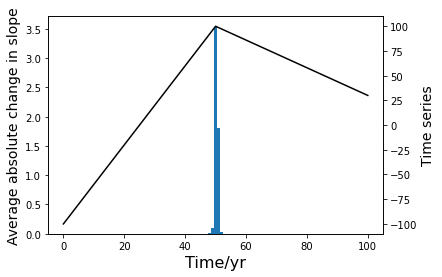

In [22]:
plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax = plt.gca()
plt.bar(left_edges[5:-5], av_delta_slope[5:-5], align='edge', width = time_intervals_edges[1] - time_intervals_edges[0])
ax2 = ax.twinx()
plt.plot([0,50,100],[-100,100,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Average absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example1_jerk_av_slope.pdf',bbox_inches='tight')

#### For this example, the binned absolute change of slope works similarly to the absolute change of slope of the averaged model.

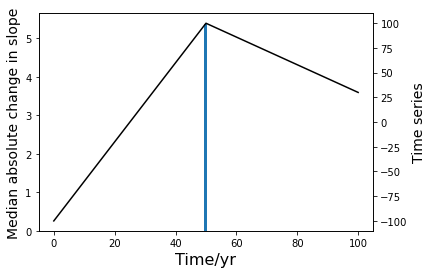

In [24]:
plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax = plt.gca()
plt.bar(left_edges[5:-5], median_delta_slope[5:-5], align='edge', width = time_intervals_edges[1] - time_intervals_edges[0])
ax2 = ax.twinx()
plt.plot([0,50,100],[-100,100,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Median absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example1_jerk_median_slope.pdf',bbox_inches='tight')

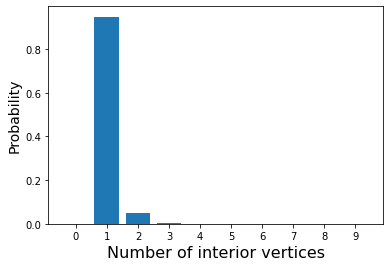

In [26]:
# Plot histogram of number of vertices
plt.figure()
plt.bar(np.arange(0,10),N_CP_hist[0:10]/np.sum(N_CP_hist),align='center',tick_label=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Number of interior vertices',fontsize=16)
plt.ylabel('Probability',fontsize=14)
plt.savefig('example1_number_vertices.pdf',bbox_inches='tight')

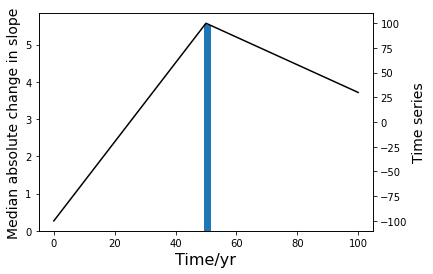

In [33]:
plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax = plt.gca()
plt.bar(left_edges[5:-5], upper_credible_delta_slope[5:-5], align='edge', width = time_intervals_edges[1] - time_intervals_edges[0])
ax2 = ax.twinx()
plt.plot([0,50,100],[-100,100,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Median absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example1_jerk_credible_slope.pdf',bbox_inches='tight')